# Exponent Comparisons

This notebook compares methods that directly estimate aperiodic exponents, including:
- spectral parameterization
- IRASA

In [1]:
# Setup notebook state
from nbutils import setup_notebook; setup_notebook()

In [2]:
import numpy as np
from scipy.stats import ttest_rel

In [3]:
from neurodsp.sim import (sim_powerlaw, sim_knee, sim_combined,
                          sim_synaptic_current, sim_combined_peak)
from neurodsp.utils import set_random_seed
from bootstrap import bootstrap_corr

In [4]:
# Import custom project code
from apm.io import APMDB
from apm.run import run_comparisons
from apm.methods import irasa, specparam
from apm.methods.settings import (SPECPARAM_PARAMS, SPECPARAM_PARAMS_KNEE,
                                  IRASA_PARAMS, IRASA_PARAMS_KNEE)
from apm.analysis.results import cohens_d
from apm.analysis.error import calculate_errors
from apm.plts import plot_dots
from apm.plts.errors import plot_boxplot_errors, plot_violin_errors
from apm.plts.utils import figsaver
from apm.plts.settings import METHOD_COLORS
from apm.sim.defs import SIM_SAMPLERS
from apm.sim.settings import FS2 as FS
from apm.utils import format_corr

## Settings

In [5]:
# Update sampling frequency for simulation definition
SIM_SAMPLERS.update_base(fs=FS)

In [6]:
# Set data specific settings
SPECPARAM_PARAMS['fs'] = FS
SPECPARAM_PARAMS_KNEE['fs'] = FS
IRASA_PARAMS['fs'] = FS
IRASA_PARAMS_KNEE['fs'] = FS

In [7]:
# Define run settings
RETURN_PARAMS = True

In [8]:
# Plot settings
DOTS_KWARGS = {
    's' : 10,
    'alpha' : 0.5,
    'color' : '#70706e',
    'xlabel' : 'Aperiodic Exponent (SP)',
    'ylabel' : 'Aperiodic Exponent (IR)',
    'figsize' : (6, 5),
}

ERROR_PLT_KWARGS = {
    'labels' : ['SP', 'IR'],
    'palette' : METHOD_COLORS,
    'saturation' : 0.85,
    'width' : 0.7,
    'figsize' : (2.5, 2),
}

In [9]:
# Settings for saving figures
SAVE_FIG = True
FIGPATH = APMDB().figs_path / '34_exp_comp'

# Create helper function to manage figsaver settings
fsaver = figsaver(SAVE_FIG, FIGPATH)

In [10]:
# Set the random seed
set_random_seed(101)

### Collect Methods

In [11]:
# Define measures to apply
measures = {
    specparam : SPECPARAM_PARAMS,
    irasa : IRASA_PARAMS,
}
measures_knee = {
    specparam : SPECPARAM_PARAMS_KNEE,
    irasa : IRASA_PARAMS_KNEE,
}

## Simulations - Samples Across Aperiodic Signals 

In [12]:
# Run simulations, comparing SpecParam & IRASA, sampling across aperiodic exponents
results_ap, sim_params_ap = run_comparisons(\
    sim_powerlaw, SIM_SAMPLERS['exp_sampler'], measures, return_params=RETURN_PARAMS)

In [13]:
# Get the simulated exponent values
sim_exps_ap = -sim_params_ap.exponent.values

#### Errors

In [14]:
# Calculate errors of each method, as compared to ground truth simulations
errors_ap = calculate_errors(results_ap, sim_exps_ap)

In [15]:
# Check the errors per method, and the difference between them
for method in errors_ap.keys():
    print('{:10s}\t{:1.4f}'.format(method, np.median(errors_ap[method])))
print('\ndifference:\t{:1.4f}'.format(\
    np.median(errors_ap['specparam']) - np.median(errors_ap['irasa'])))

specparam 	0.0503
irasa     	0.0195

difference:	0.0308


#### Statistics

In [16]:
# Check the statistical difference between measure errors
ttest_rel(errors_ap['specparam'], errors_ap['irasa'])

TtestResult(statistic=25.42327060910109, pvalue=2.3290784200192167e-110, df=999)

In [17]:
# Compute the effect size of the difference between method errors
cohens_d(errors_ap['specparam'], errors_ap['irasa'])

1.071171251325719

### Visualize

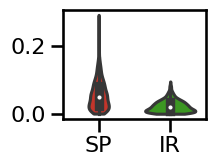

In [18]:
# Plot the errors - violinplot
plot_violin_errors(errors_ap, **ERROR_PLT_KWARGS)

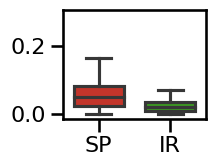

In [19]:
# Plot the errors - boxplot
plot_boxplot_errors(errors_ap, **ERROR_PLT_KWARGS, **fsaver('spec_irasa_exp_errors'))

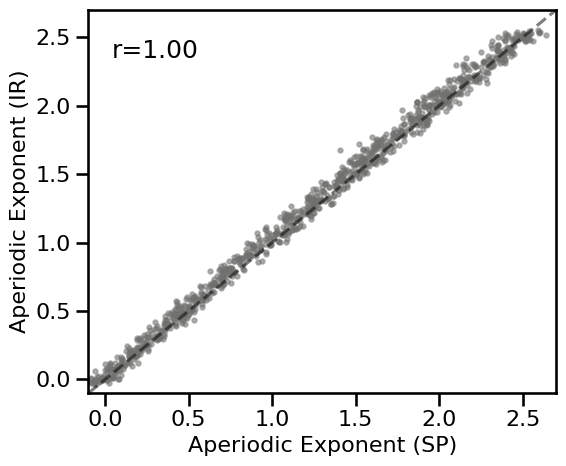

In [20]:
# Plot the comparison between specparam and IRASA
plot_dots(results_ap['specparam'], results_ap['irasa'], tposition='tl', **DOTS_KWARGS,
          expected=[-0.1, 2.75], xlim=[-0.1, 2.7], ylim=[-0.1, 2.7],
          **fsaver('spec_irasa_exp'))

In [21]:
# Check correlations
corrs_ap = bootstrap_corr(results_ap['specparam'], results_ap['irasa'])
print('  SP & IR:  ', format_corr(*corrs_ap))

  SP & IR:   r=+0.997  CI[+0.997, +0.997],  p=0.000


## Simulations - Samples Across Combined Signals 

In [22]:
# Run simulations, comparing SpecParam & IRASA, sampling across combined signal parameters
results_comb, sim_params_comb = run_comparisons(\
    sim_combined, SIM_SAMPLERS['comb_sampler'], measures, return_params=RETURN_PARAMS)

In [23]:
# Get the simulated exponent values
sim_exps_comb = -sim_params_comb.exponent.values

#### Errors

In [24]:
# Calculate errors of each method, as compared to ground truth simulations
errors_comb = calculate_errors(results_comb, sim_exps_comb)

In [25]:
# Check the errors per method
for method in errors_comb.keys():
    print('{:10s}\t{:1.4f}'.format(method, np.median(errors_comb[method])))
print('\ndifference:\t{:1.4f}'.format(\
    np.median(errors_comb['specparam']) - np.median(errors_comb['irasa'])))

specparam 	0.0357
irasa     	0.0194

difference:	0.0163


#### Statistics

In [26]:
# Check the statistical difference between measure errors
ttest_rel(errors_comb['specparam'], errors_comb['irasa'])

TtestResult(statistic=17.101023541019725, pvalue=1.0559309401684798e-57, df=999)

In [27]:
# Compute the effect size of the difference between method errors
cohens_d(errors_comb['specparam'], errors_comb['irasa'])

0.7293764049652732

### Visualize

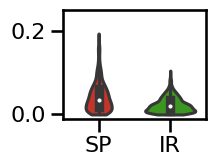

In [28]:
# Plot the errors - violinplot
plot_violin_errors(errors_comb, **ERROR_PLT_KWARGS, ylim=[-0.01, 0.25])

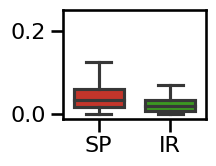

In [29]:
# Plot the errors - boxplot
plot_boxplot_errors(errors_comb, ylim=[-0.01, 0.25],
                    **ERROR_PLT_KWARGS, **fsaver('spec_irasa_comb_errors'))

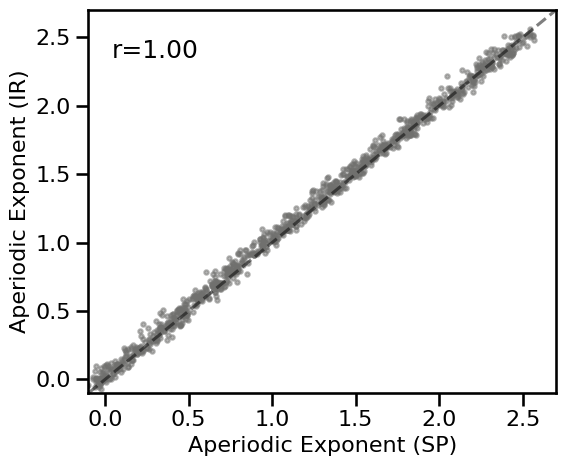

In [30]:
# Plot the comparison between specparam and IRASA
plot_dots(results_comb['specparam'], results_comb['irasa'], tposition='tl', **DOTS_KWARGS,
          expected=[-0.1, 2.75], xlim=[-0.1, 2.7], ylim=[-0.1, 2.7], **fsaver('spec_irasa_comb'))

In [31]:
# Check correlations
corrs_comb = bootstrap_corr(results_comb['specparam'], results_comb['irasa'])
print('  SP & IR:  ', format_corr(*corrs_comb))

  SP & IR:   r=+0.998  CI[+0.998, +0.998],  p=0.000


## Simulations - Across Timescales (Synaptic Sims)

In [32]:
# Run simulations, comparing SpecParam & IRASA, sampling across timescale values
results_tscale, sim_params_tscale = run_comparisons(\
    sim_synaptic_current, SIM_SAMPLERS['tscale_sampler'],
    measures_knee, return_params=RETURN_PARAMS)

In [33]:
# Define the expected aperiodic exponent for the synapse knee model
sim_exps_tscale = np.ones(SIM_SAMPLERS.n_samples) * 2

#### Errors

In [34]:
# Calculate errors of each method, as compared to ground truth simulations
errors_tscale = calculate_errors(results_tscale, sim_exps_tscale)

In [35]:
# Check the errors per method
for method in errors_tscale.keys():
    print('{:10s}\t{:1.4f}'.format(method, np.median(errors_tscale[method])))
print('\ndifference:\t{:1.4f}'.format(\
    np.median(errors_tscale['specparam']) - np.median(errors_tscale['irasa'])))

specparam 	0.0629
irasa     	0.0669

difference:	-0.0040


#### Statistics

In [36]:
# Check the statistical difference between measure errors
ttest_rel(errors_tscale['specparam'], errors_tscale['irasa'])

TtestResult(statistic=-3.7429900350805534, pvalue=0.0001922154900069521, df=999)

In [37]:
# Compute the effect size of the difference between method errors
cohens_d(errors_tscale['specparam'], errors_tscale['irasa'])

-0.12402656493705909

### Visualize

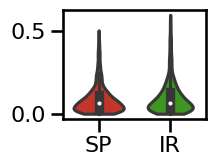

In [38]:
# Plot the errors - violinplot
plot_violin_errors(errors_tscale, **ERROR_PLT_KWARGS)

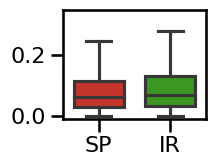

In [39]:
# Plot the errors - boxplot
plot_boxplot_errors(errors_tscale, ylim=[-0.01, 0.35], 
                    **ERROR_PLT_KWARGS, **fsaver('spec_irasa_tscale_errors'))

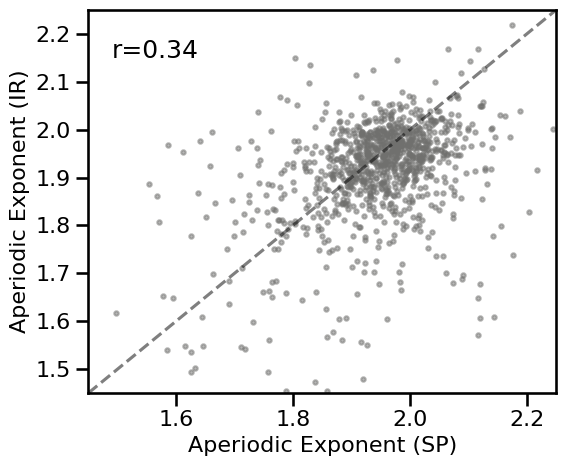

In [40]:
# Plot the comparison between specparam and IRASA
plot_dots(results_tscale['specparam'], results_tscale['irasa'], tposition='tl',
          expected=[1.45, 2.25], xlim=[1.45, 2.25], ylim=[1.45, 2.25], 
          **DOTS_KWARGS, **fsaver('spec_irasa_tscale'))

In [41]:
# Check correlations
corrs_knee = bootstrap_corr(results_tscale['specparam'], results_tscale['irasa'])
print('  SP & IR:  ', format_corr(*corrs_knee))

  SP & IR:   r=+0.343  CI[+0.281, +0.404],  p=0.000


## Simulations - Across Knees

In [42]:
# Run simulations, comparing SpecParam & IRASA, sampling across knee values
results_knee, sim_params_knee = run_comparisons(\
    sim_knee, SIM_SAMPLERS['knee_sampler'], measures_knee, return_params=RETURN_PARAMS)

In [43]:
# Get the simulated exponent values
sim_exps_knee = -1 * sim_params_knee.exponent2.values

#### Errors

In [44]:
# Calculate errors of each method, as compared to ground truth simulations
errors_knee = calculate_errors(results_knee, sim_exps_knee)

In [45]:
# Check the errors per method
for method in errors_knee.keys():
    print('{:10s}\t{:1.4f}'.format(method, np.nanmedian(errors_knee[method])))
print('\ndifference:\t{:1.4f}'.format(\
    np.nanmedian(errors_knee['specparam']) - np.nanmedian(errors_knee['irasa'])))

specparam 	0.0753
irasa     	0.1110

difference:	-0.0357


#### Statistics

In [46]:
# Check the statistical difference between measure errors
ttest_rel(errors_knee['specparam'], errors_knee['irasa'], nan_policy='omit')

TtestResult(statistic=2.137320194161163, pvalue=0.032815205492808926, df=995)

In [47]:
# Compute the effect size of the difference between method errors
cohens_d(errors_knee['specparam'], errors_knee['irasa'])

0.08243276198951752

### Visualize

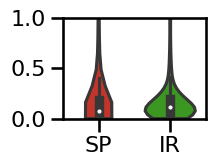

In [48]:
# Plot the errors - violinplot
plot_violin_errors(errors_knee, **ERROR_PLT_KWARGS, ylim=[0, 1])

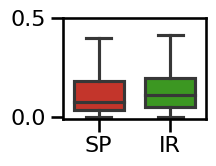

In [49]:
# Plot the errors - boxplot
plot_boxplot_errors(errors_knee, ylim=[-0.01, 0.5],
                    **ERROR_PLT_KWARGS, **fsaver('spec_irasa_knee_errors'))

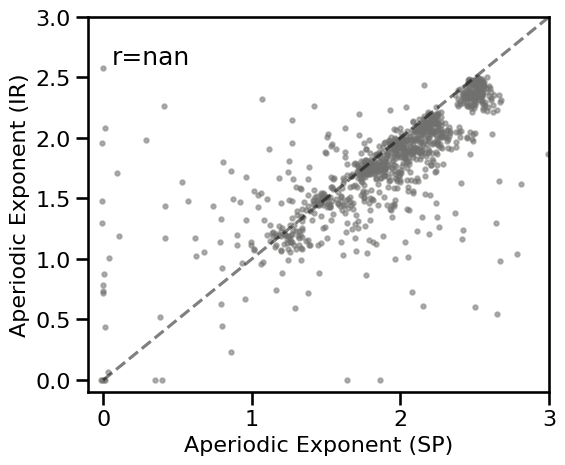

In [50]:
# Plot the comparison between specparam and IRASA
plot_dots(results_knee['specparam'], results_knee['irasa'], tposition='tl',
          expected=[0.0, 3.], xlim=[-0.1, 3], ylim=[-0.1, 3], 
          **DOTS_KWARGS, **fsaver('spec_irasa_knee'))

In [51]:
# Check correlations
corrs_knee = bootstrap_corr(results_tscale['specparam'], results_tscale['irasa'])
print('  SP & IR:  ', format_corr(*corrs_knee))

  SP & IR:   r=+0.343  CI[+0.280, +0.402],  p=0.000


## Simulations - Samples Across Peak Signals 

In [52]:
# Run simulations, comparing SpecParam & IRASA, sampling across peak signals
results_bw, sim_params_bw = run_comparisons(\
    sim_combined_peak, SIM_SAMPLERS['peak_sampler'], measures, return_params=RETURN_PARAMS)

In [53]:
# Get the simulated exponent values
sim_exps_bw = -sim_params_bw.exponent.values

In [54]:
# Calculate errors of each method, as compared to ground truth simulations
errors_bw = calculate_errors(results_bw, sim_exps_bw)

#### Errors

In [55]:
# Check the errors per method
for method in errors_bw.keys():
    print('{:10s}\t{:1.4f}'.format(method, np.median(errors_bw[method])))
print('\ndifference:\t{:1.4f}'.format(\
    np.median(errors_bw['specparam']) - np.median(errors_bw['irasa'])))

specparam 	0.0553
irasa     	0.1377

difference:	-0.0824


#### Statistics

In [56]:
# Check the statistical difference between measure errors
ttest_rel(errors_bw['specparam'], errors_bw['irasa'])

TtestResult(statistic=-24.826045176664056, pvalue=2.3264616334450653e-106, df=999)

In [57]:
# Compute the effect size of the difference between method errors
cohens_d(errors_bw['specparam'], errors_bw['irasa'])

-0.9161249711756813

### Visualize

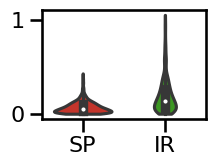

In [58]:
# Plot the errors - violinplot
plot_violin_errors(errors_bw, **ERROR_PLT_KWARGS)

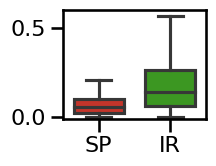

In [59]:
# Plot the errors - boxplot
plot_boxplot_errors(errors_bw, ylim=[-0.01, 0.60],
                    **ERROR_PLT_KWARGS, **fsaver('spec_irasa_bw_errors'))

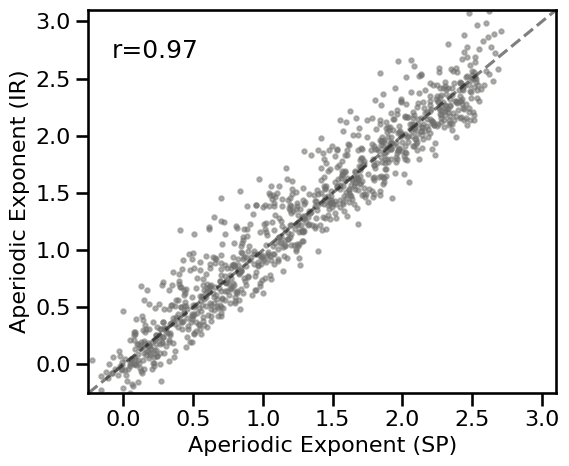

In [60]:
# Plot the comparison between specparam and IRASA
plot_dots(results_bw['specparam'], results_bw['irasa'], tposition='tl', 
          expected=[-0.25, 3.1], xlim=[-0.25, 3.1], ylim=[-0.25, 3.1],
          **DOTS_KWARGS, **fsaver('spec_irasa_bw'))

In [61]:
# Check correlation
corrs_bw = bootstrap_corr(results_bw['specparam'], results_bw['irasa'])
print('  SP & IR:  ', format_corr(*corrs_bw))

  SP & IR:   r=+0.966  CI[+0.961, +0.969],  p=0.000


## Conclusions

Comparing between these methods, overall we can see that:
- In simple cases (powerlaw + oscillations), specparam and IRASA perform very similarly